Project 4: Generative Adversarial Networks
======
In this project, you are expected to fill in the missing parts of a PyTorch implementation of the Deep Convolutional Generative Adversarial Network (DCGAN) and test its performance on several datasets.

We will be using datasets with small images for this project, because high-resolution GANs take notoriously long to train.

**References:**

[1] [Radford, A., Metz, L. and Chintala, S., 2015. Unsupervised representation learning with deep convolutional generative adversarial networks. arXiv preprint arXiv:1511.06434.](https://arxiv.org/abs/1511.06434)

[2] [MNIST dataset.](http://yann.lecun.com/exdb/mnist/)

[3] [FashionMNIST dataset.](https://github.com/zalandoresearch/fashion-mnist)


### Verify your PyTorch installation

In [1]:
import torch
import torchvision

# Print Basic Information
print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
print("Torchvision", torchvision.__version__)
print('Device:', torch.device('cuda:0'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
workers = 4 # The number of parallel processes used to read data
gpu_id = [0,1,2,3] # only modify if you machine has more than one GPU card
torch.cuda.device_count()

Torch 1.3.0 CUDA 10.1.243
Torchvision 0.4.1a0+d94043a
Device: cuda:0


4

In [2]:
#import statements
import os, time
import matplotlib.pyplot as plt
import itertools
import pickle
import imageio
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.autograd import Variable
from torchsummary import summary
import numpy as np

In [3]:
epochs = 20
batch_size = 128
learning_rate = 0.0002
workers = 4 # The number of parallel processes used to read data
gpu_id = [0,1,2,3] # only modify if you machine has more than one GPU card

In [4]:
#######################################################################################################
# TODO 2: choose sensible training parameters for DCGAN training. 
# Start with few epochs while you design the network, and increase once you think you have a good setup.
# Since GANs train slowly, you may have to use at quite a few epochs to see good results.
#######################################################################################################
batch_size = 128
lr = 0.0002
num_epochs = 20

nz = 100 #length of latent vector
ngf = 128 #relates to the depth of feature maps carried through the generator
ndf = 128 # Size of feature maps in discriminator
nc = 1  #number of color channels in the input images.

            

## Assignment 4B: Conditional DCGAN

Our previous Generator network was generating random outputs for each input latent vector. 
Now, we would like to add some control mechanism such that we can determine the class for a generated image, e.g. generate only the number $5$ or images from the category $Shirt$.

The expected output of this GAN should look like this (or better):

<img src="img/cond_DCGAN_MNIST.png" align='left' width="550">
<img src="img/cond_DCGAN_fashionMNIST.png" align='left' width="550">

For simplicity, we will use either _MNIST_ or _FashionMNIST_ at $32\times32$ grayscale for this exercise again.

For a class-conditioned output, we need to modify both the generator as well as the discriminator network to accept a class label as part of the input. These labels need to be transformed from a "categorical" input to a numerical vector. Use `torch.nn.Embedding` to transform the label to such an embedding space.

### 8) Modify Networks for conditional GANs (4 points)

Select appropriate training hyperparameters.

In [5]:
# TODO: choose reasonable values
batch_size = 128
num_epochs = 20
learning_rate = 0.0002

### 9) Design a conditional discriminator network (8 points)

Below diagrams shows the architecture that you're expected to implement

<img src="img/DCGAN_Discriminator_conditional.png" align='left' width="900">

In [6]:
#######################################################################################################
#TODO 9: update the discriminator network to incorporate the label input
#######################################################################################################

class Discriminator(nn.Module):
    def __init__(self,n_classes=10):
        super(Discriminator, self).__init__()
        #pass # TODO add your implementation
        self.embedding = nn.Embedding(n_classes, 50)
        self.fc = nn.Linear(50, 64)
        
        self.discriminator1 = nn.Sequential(
            # input is (nc) x 32x 32
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.discriminator2 = nn.Sequential(
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(ndf * 2+1, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    # forward method
    def forward(self, x, labels):
        #return None # TODO add your implementation
        x = self.discriminator1(x)
        embedding = self.embedding(labels)
        condition = self.fc(embedding).view(-1,1,8,8)
        x = torch.cat((x, condition), 1)
        x = self.discriminator2(x)
        return x

### 8) Design a conditional generator network (8 points)

<img src="img/DCGAN_Generator_conditional.png" align='left' width="900">

In [9]:
# plot the losses over time as a curve            
def plot_losses(hist, show=True, save=False, path='progress.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Iteration')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

In [7]:
#######################################################################################################
#TODO 10: update the generator network to incorporate the label input
#######################################################################################################

class Generator(nn.Module):
    def __init__(self,n_classes=10):
        super(Generator, self).__init__()
        #pass # TODO add your implementation
        self.embedding = nn.Embedding(n_classes, 50)
        self.fc = nn.Linear(50, 64)
        
        self.generator1 = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( 100, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True)
        )
        self.generator2 = nn.Sequential(
            # state size. (ngf*2) x 8 x 8
            nn.ConvTranspose2d( ngf * 2+1, ngf * 1, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 1),
            nn.ReLU(True),
            # state size. (ngf) x 16 x 16
            nn.ConvTranspose2d( ngf*1, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    # forward method
    def forward(self, x, labels):
        #return None # TODO add your implementation
        x = self.generator1(x)
        embedding = self.embedding(labels)
        condition = self.fc(embedding).view(-1,1,8,8)
        x = torch.cat((x, condition), 1)
        x = self.generator2(x)
        return x

#### Complete the output function (5 points)

In [8]:
# output generated samples from the current state of the generator network
n_samples = 5

#######################################################################################################
# TODO 11: generate a fixed noise vector and a fixed set of labels to evaluate the output of the generator
# with the same noise parameters as training progresses.
# Arrange the labels into a grid to show same label outputs in the same column (see example results above) 
#######################################################################################################
fixed_z =  torch.randn(n_samples*2,nz,1,1).to(device)
fixed_labels = torch.LongTensor(np.arange(10)).to(device)

def show_conditional_result(num_epoch, show=False, save=False, n_classes=10, n_samples=5, path='result.png', useFixed=False):
    with torch.no_grad():
        if useFixed:   
            fake = G(fixed_z, fixed_labels).cpu()
        else:
            # TODO generate a new random noise vector and a grid of labels
            z = torch.randn(n_samples*2,nz,1,1).to(device)
            labels = torch.LongTensor(n_samples*2).random_(0, 10).to(device)

            fake = G(z, labels).cpu()

        fig, ax = plt.subplots(figsize=(20, 10))
        image = utils.make_grid(fake.data, n_classes, 1, normalize=True)

        plt.imshow(np.transpose(image, (1, 2, 0)))

        ax.axis('off')

        plt.savefig(path)

        if show:
            plt.show()
        else:
            plt.close()   

In [12]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        #nn.init.constant_(m.bias.data, 0)
    #elif classname.find('BatchNorm') != -1:
     #   nn.init.normal_(m.weight.data, 1.0, 0.02)
      #  nn.init.constant_(m.bias.data, 0)

#### Complete the training setup (5 points) and training loop (10 points)

Training ...
Epoch [1 / 20] G loss: 2.863553285598755 D loss: 0.2333361804485321


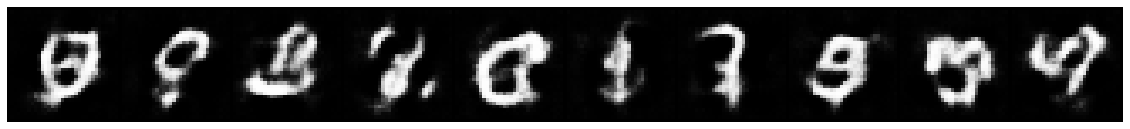

Epoch [2 / 20] G loss: 1.3317742347717285 D loss: 8.326894760131836


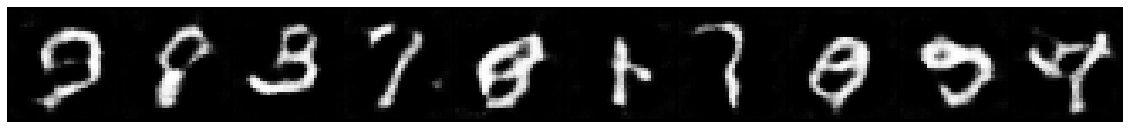

Epoch [3 / 20] G loss: 1.318243145942688 D loss: 0.9562032222747803


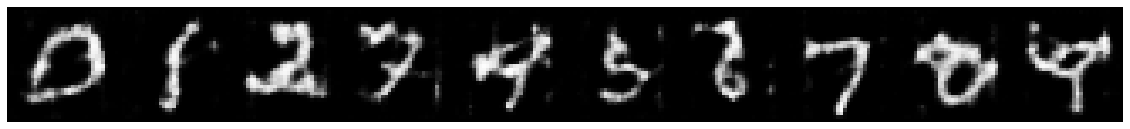

Epoch [4 / 20] G loss: 1.6987099647521973 D loss: 0.6766613125801086


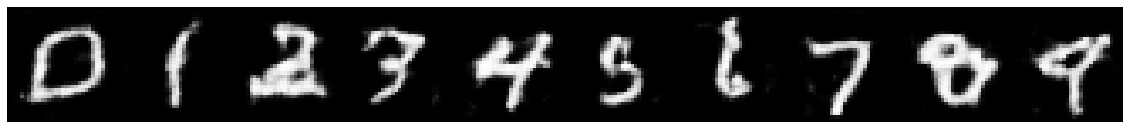

Epoch [5 / 20] G loss: 4.304948806762695 D loss: 0.07198922336101532


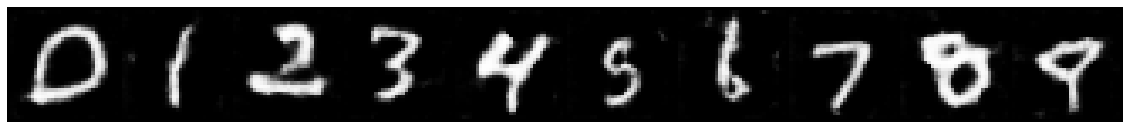

Epoch [6 / 20] G loss: 4.650038719177246 D loss: 0.05825572460889816


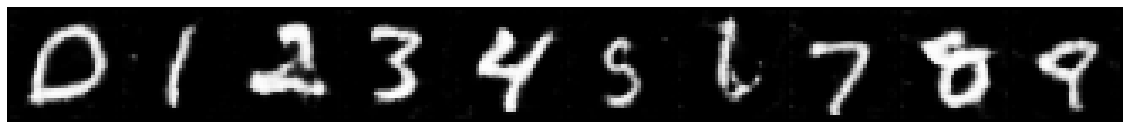

Epoch [7 / 20] G loss: 2.9124510288238525 D loss: 0.6736507415771484


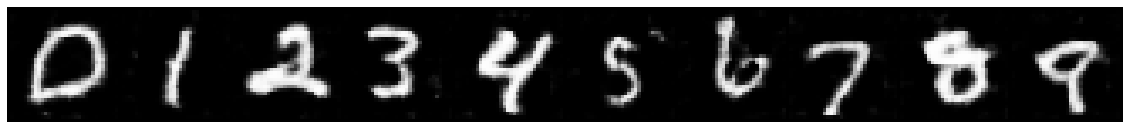

Epoch [8 / 20] G loss: 4.219425678253174 D loss: 0.06655851006507874


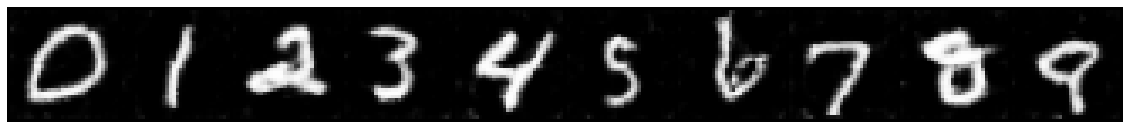

Epoch [9 / 20] G loss: 5.3721489906311035 D loss: 0.036518704146146774


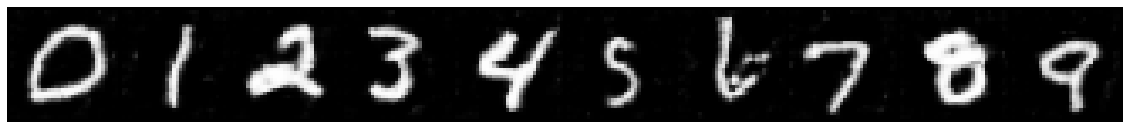

Epoch [10 / 20] G loss: 4.3730669021606445 D loss: 0.0326114296913147


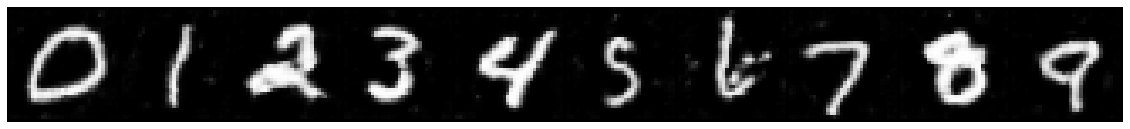

Epoch [11 / 20] G loss: 5.820913791656494 D loss: 0.058769844472408295


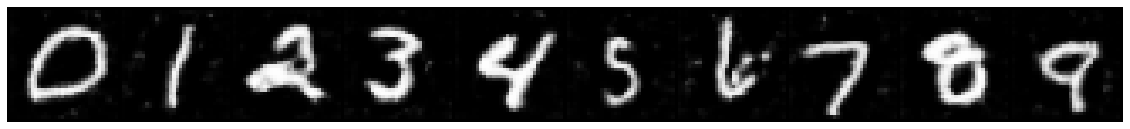

Epoch [12 / 20] G loss: 6.348551273345947 D loss: 0.007662646938115358


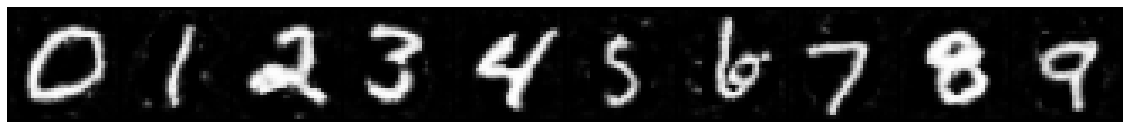

Epoch [13 / 20] G loss: 5.0517964363098145 D loss: 0.02144451066851616


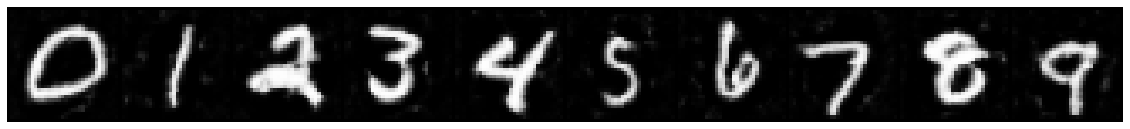

Epoch [14 / 20] G loss: 3.4220306873321533 D loss: 0.14251309633255005


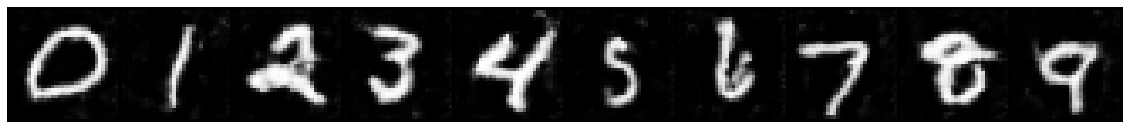

Epoch [15 / 20] G loss: 3.7629072666168213 D loss: 0.15172773599624634


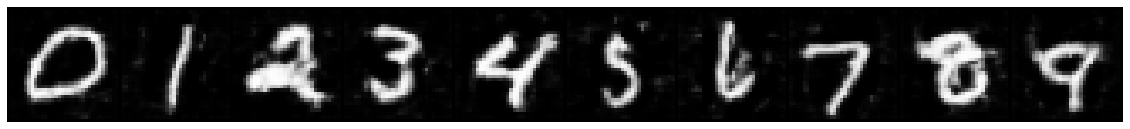

Epoch [16 / 20] G loss: 6.986948490142822 D loss: 0.008242156356573105


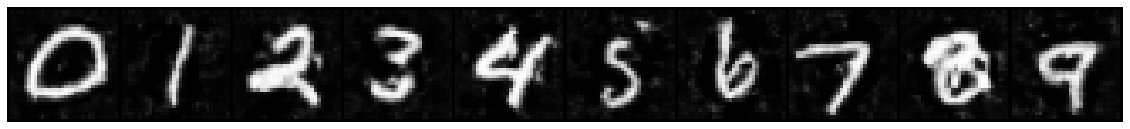

Epoch [17 / 20] G loss: 4.271143436431885 D loss: 0.06355177611112595


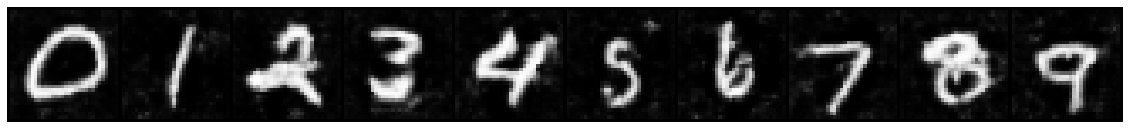

Epoch [18 / 20] G loss: 2.25083327293396 D loss: 0.3445023000240326


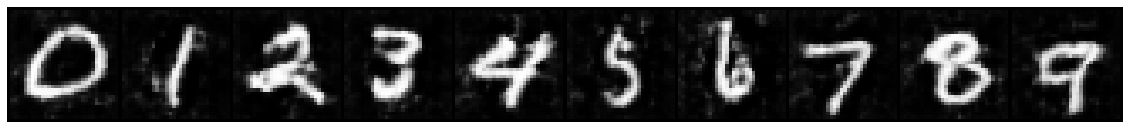

Epoch [19 / 20] G loss: 3.2210066318511963 D loss: 0.14023864269256592


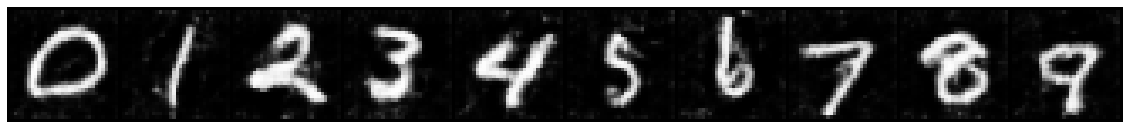

Epoch [20 / 20] G loss: 4.972275257110596 D loss: 0.03209128975868225


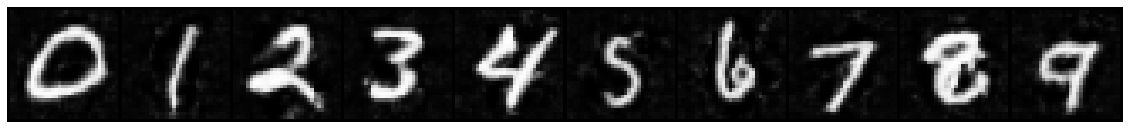

Avg per epoch time: 28.85 sec, total 20 epochs time: 9.77 min
Training finished!
...saving training results


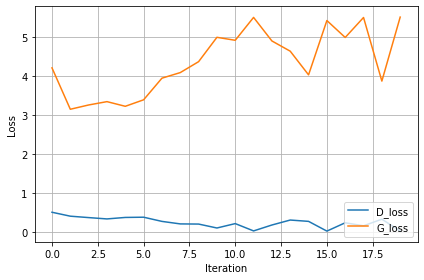

In [14]:
plt.ion()

# define dataloader
train_dataset = datasets.MNIST(root='./minst',download=True,
                           transform=transforms.Compose([
                               transforms.Resize(32),
                               transforms.CenterCrop(32),
                               ####Data Augmenttation
                               #transforms.RandomHorizontalFlip(),  
                               #transforms.RandomRotation(20),
                               #transforms.RandomVerticalFlip(),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                           ]))
data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=workers)
dset_name = 'myDataset'
result_dir = '{}_conditional_DCGAN'.format(dset_name)

# results save folder
if not os.path.isdir(result_dir):
    os.mkdir(result_dir)
    
device = torch.device("cuda:0")

#######################################################################################################
# TODO 12: define training setup
#######################################################################################################

# TODO define networks
G = Generator().to(device)
G = nn.DataParallel(G, device_ids=[g for g in gpu_id])
D = Discriminator().to(device)
D = nn.DataParallel(D, device_ids=[g for g in gpu_id])

#######Initize weights
G.apply(weights_init)
D.apply(weights_init)

# define optimizers
# Initialize BCELoss function
criterion = nn.BCELoss()
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))


progress = {}
progress['D_losses'] = []
progress['G_losses'] = []
progress['per_epoch_times'] = []
progress['total_time'] = []
num_iter = 0

# start training loop
print('Training ...')
start_time = time.time()
for epoch in range(num_epochs):
    
    D_losses = []
    G_losses = []
    
    epoch_start_time = time.time()
    num_batches = 0
    
    for real, real_labels in data_loader:
        
        #######################################################################################################
        # TODO 13: Fill code for training loop
        #######################################################################################################
        real = real.to(device)
        real_labels = real_labels.to(device)
        batch_size = real.size(0)    ###For the end of the dataset
        # generate random latent vector z and random class assignments for each generated image in the minibatch as well as real and fake labels 
    
        # TODO 
        z = torch.randn(batch_size, nz, 1, 1).to(device)
        random_labels = torch.LongTensor(batch_size).random_(0, 10).to(device)
        real_label = torch.full((batch_size,), 1).to(device)
        fake_label = torch.full((batch_size,), 0).to(device)
        # generate fakes
        fakes = G(z, random_labels).to(device)

        # TODO 
        
        # evaluate fakes
        D_fake_loss = criterion(D(fakes.detach(),random_labels).view(-1), fake_label)
        
        # TODO 

        # evaluate real minibatch
        D_real_loss = criterion(D(real, real_labels).view(-1), real_label)
         
        # TODO
        
        # accumulate discriminator loss from the information about the real and fake images it just saw
        D_train_loss = D_fake_loss + D_real_loss
                

        # train discriminator D step
        D.zero_grad()
        D_train_loss.backward()
        D_optimizer.step() 
        
        # train generator to output an image that is classified as real              
        G_train_loss = criterion(D(fakes, random_labels).view(-1), real_label)  
        
        # train generator G step
        G.zero_grad()
        G_train_loss.backward()
        G_optimizer.step()              

        D_losses.append(D_train_loss.data.item())
        G_losses.append(G_train_loss.data.item())
        
        epoch_end_time = time.time()
    per_epoch_time = epoch_end_time - epoch_start_time
    
    print('Epoch [{} / {}] G loss: {} D loss: {}'.format(epoch + 1, num_epochs, G_train_loss, D_train_loss))

    show_conditional_result( epoch, save=True, show=True, path=result_dir + '/{}_conditional_DCGAN_{}.png'.format(dset_name, epoch), useFixed=True )
    progress['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)))
    progress['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)))
    progress['per_epoch_times'].append(per_epoch_time)
     
end_time = time.time()
total_time = end_time - start_time
progress['total_time'].append(total_time)

print('Avg per epoch time: {:.2f} sec, total {:d} epochs time: {:.2f} min'.format(torch.mean(torch.FloatTensor(progress['per_epoch_times'])), num_epochs, total_time / 60))
print('Training finished!')
print('...saving training results')

torch.save(G.state_dict(), result_dir + '/generator_network.pkl')
torch.save(D.state_dict(), result_dir + '/discriminator_network.pkl')
with open(result_dir + '/progress.pkl', 'wb') as f:
    pickle.dump(progress, f)

# plot loss curves
plot_losses(progress, save=True, path=result_dir + '/{}_DCGAN_progress.png'.format(dset_name))

# show training progress as animation
images = []
for e in range(num_epochs):
    img_name = result_dir + '/{}_conditional_DCGAN_{}.png'.format(dset_name, e)
    images.append(imageio.imread(img_name))
imageio.mimsave(result_dir + '/conditional_DCGAN_generation_animation.gif', images, fps=5)

### Display the animated generation GIF

% edit path to GIF %
<img src='myDataset_conditional_DCGAN/conditional_DCGAN_generation_animation.gif' width="512">